# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents')
sys.path.append('../../../RL_lib/Policies/AWR')
sys.path.append('../../../RL_lib/Policies/Common')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Env')
sys.path.append('../../../Imaging')


%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/Asteroid_CPO_seeker-master/Experiments/Extended/Test_HF


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 1.0000000e+00  0.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]
[ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]
using max  pooling
V4: Output State type:  <function Sensor.optflow_state_range_dp1 at 0x137ee6378>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x13a2650f0>>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x13a2650f0>>
6dof dynamics model 
thruster model: 
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Lander Model: 
Reward_terminal equator
queue fixed
Flat Constraint
Attitude Constraint
Rotational Velocity Constraint
Position Hysterises Constraint


<IPython.core.display.Javascript object>


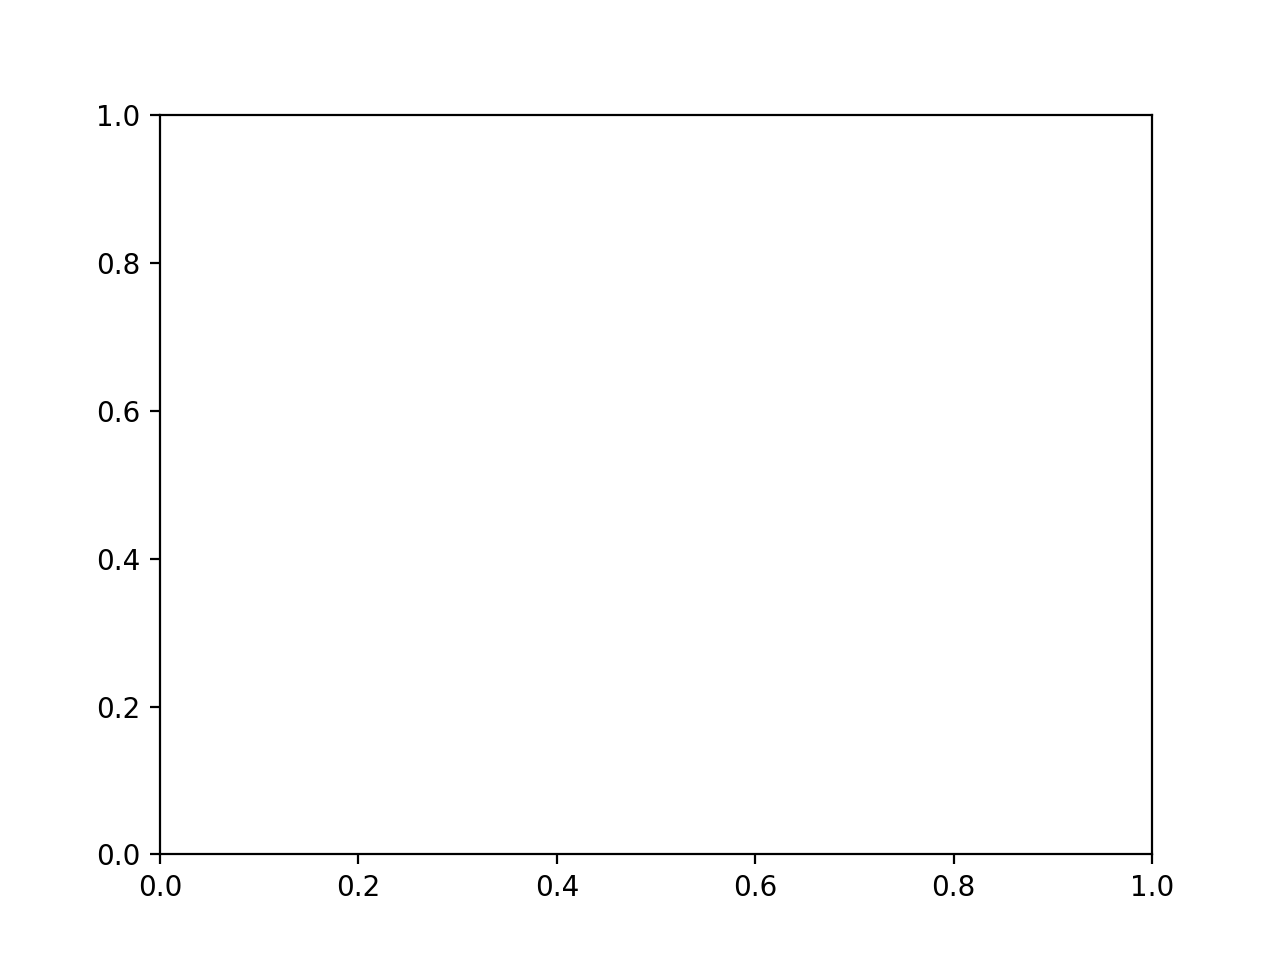

<IPython.core.display.Javascript object>


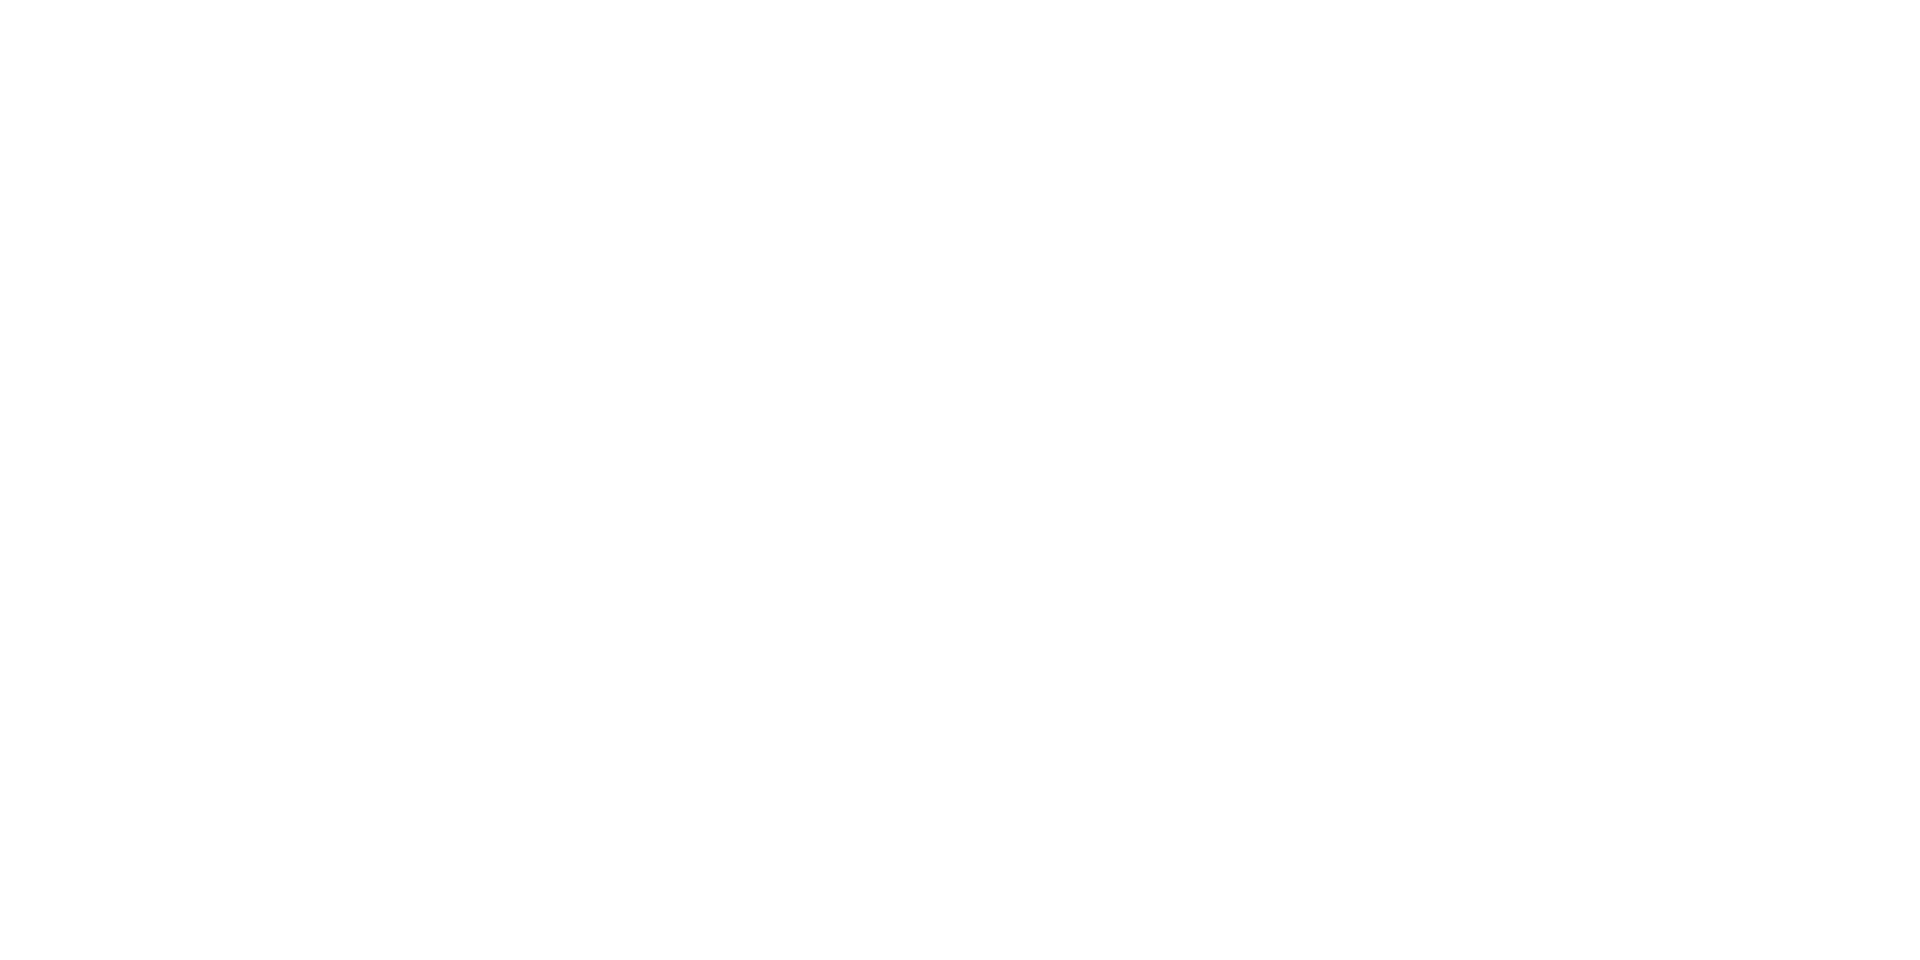

<IPython.core.display.Javascript object>


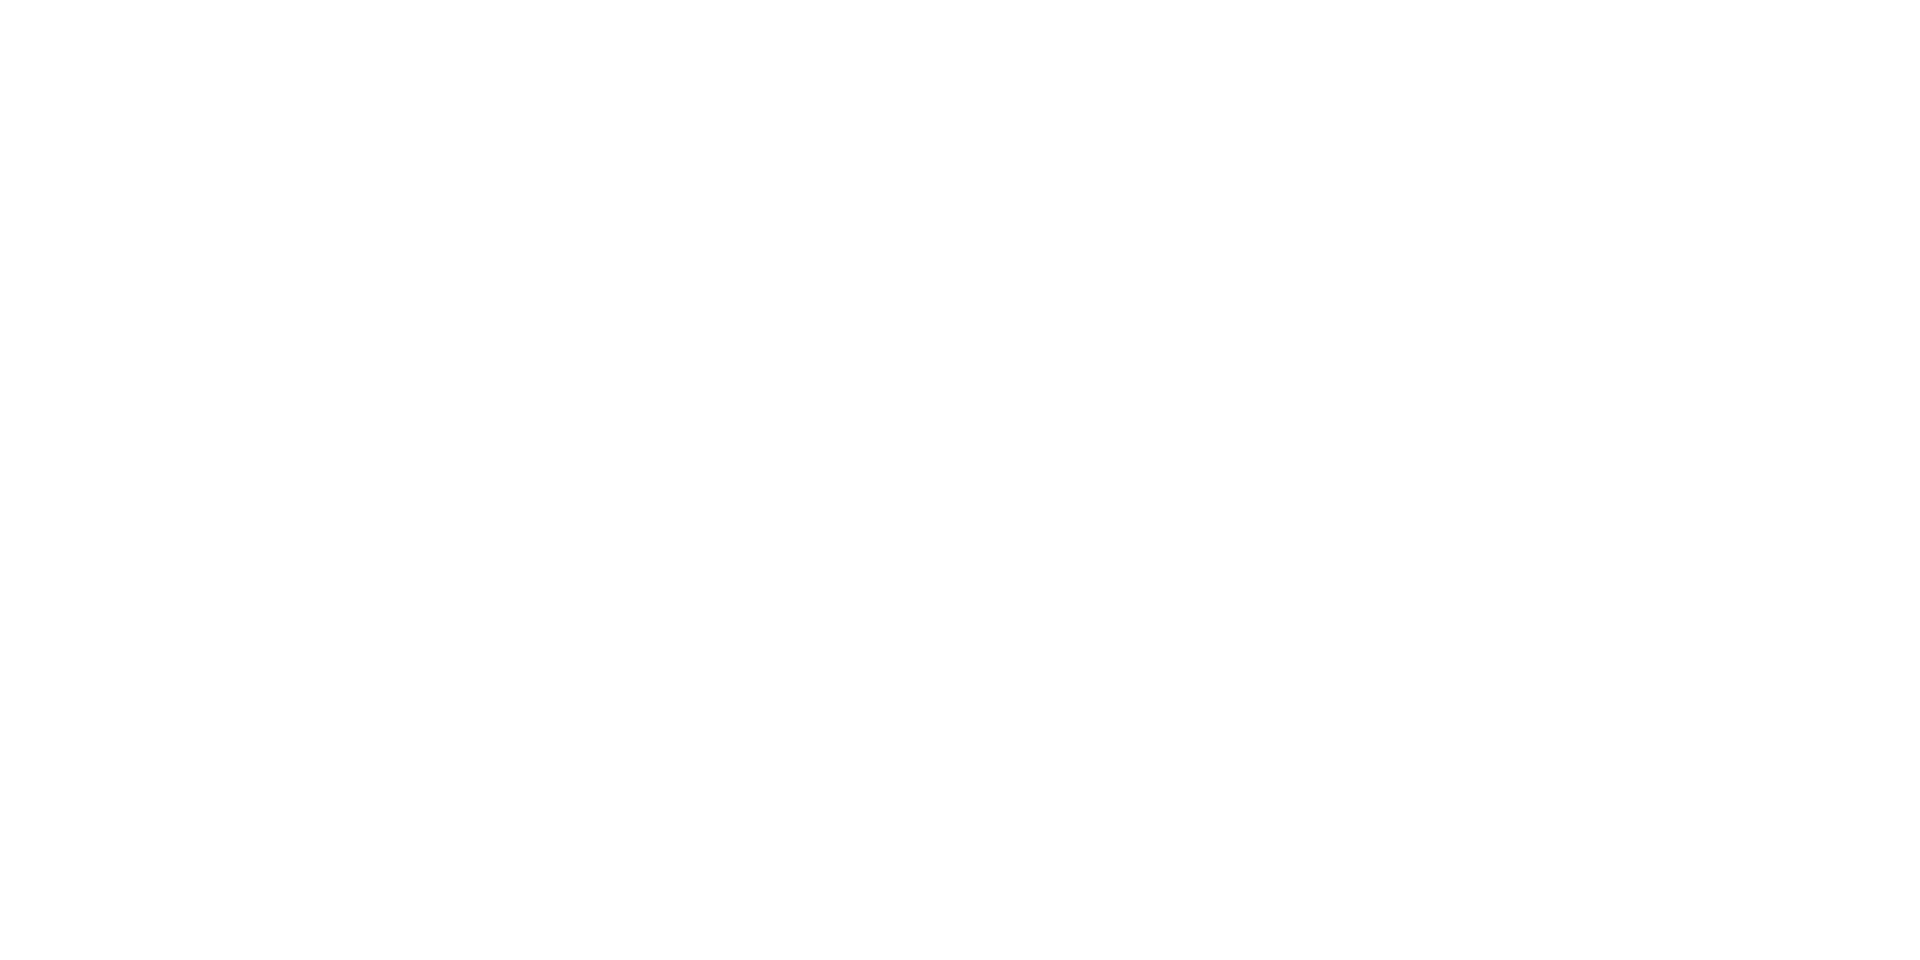

<IPython.core.display.Javascript object>


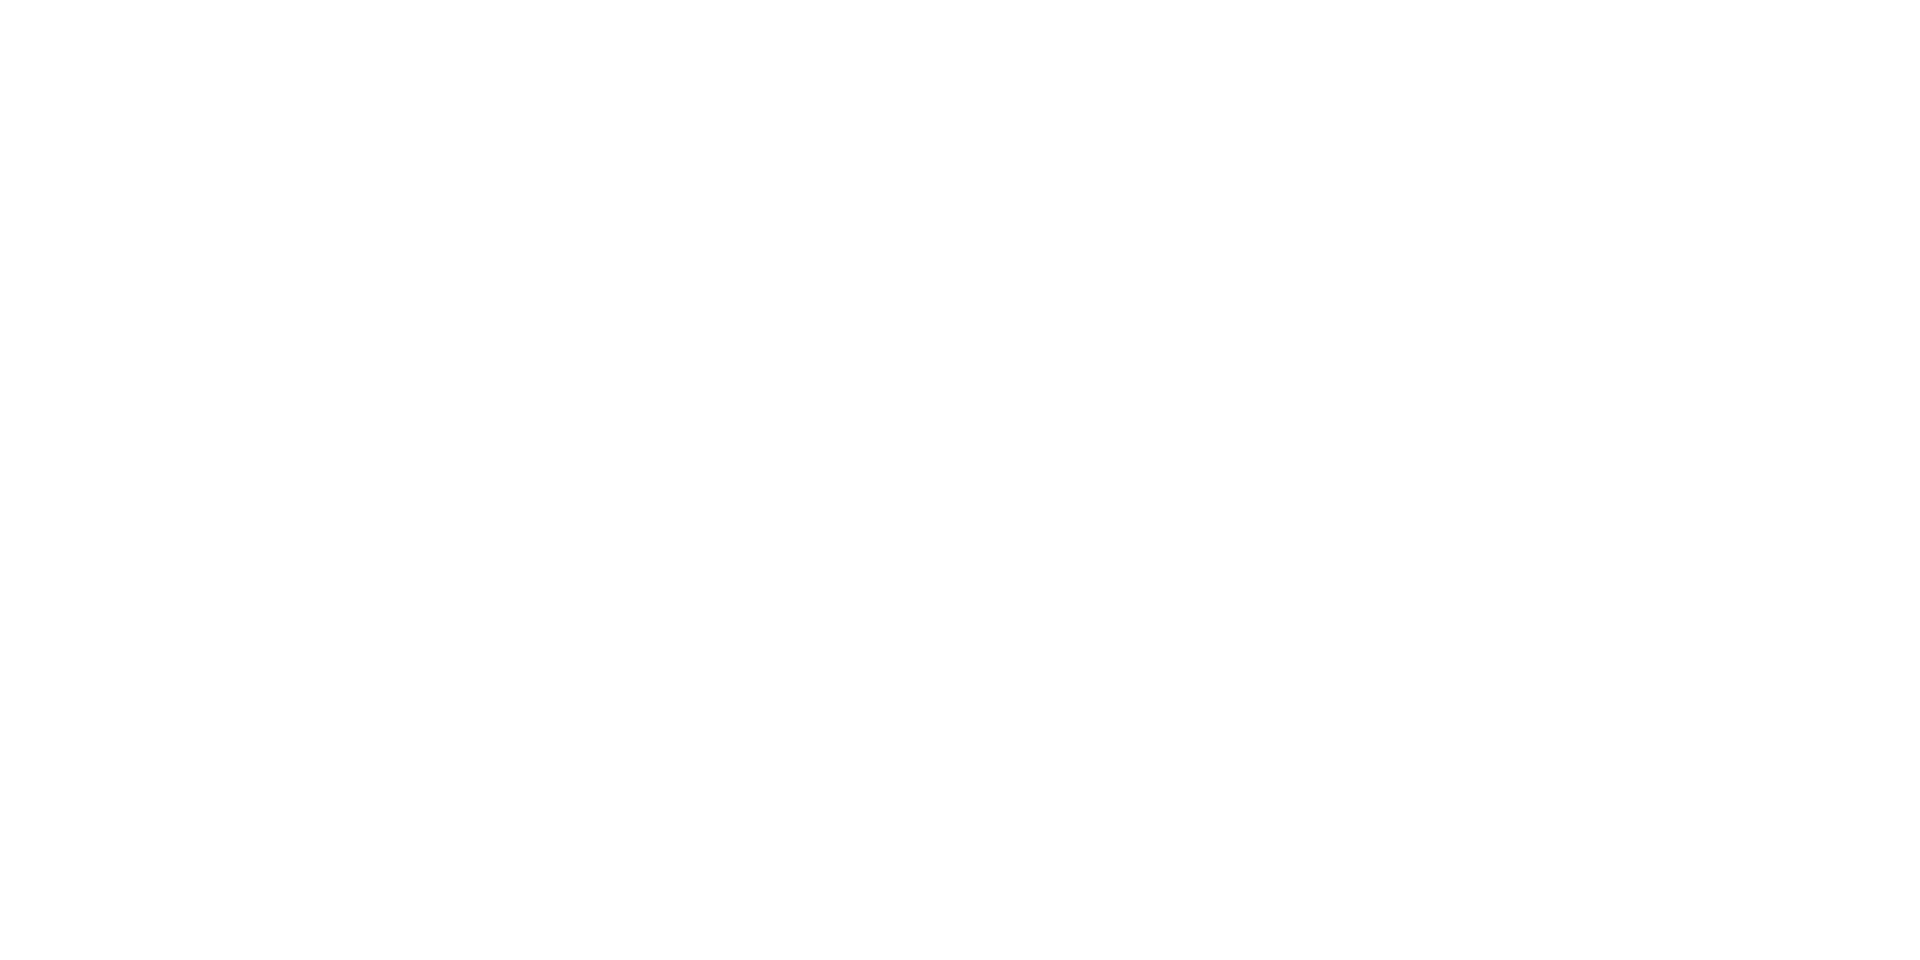

<IPython.core.display.Javascript object>


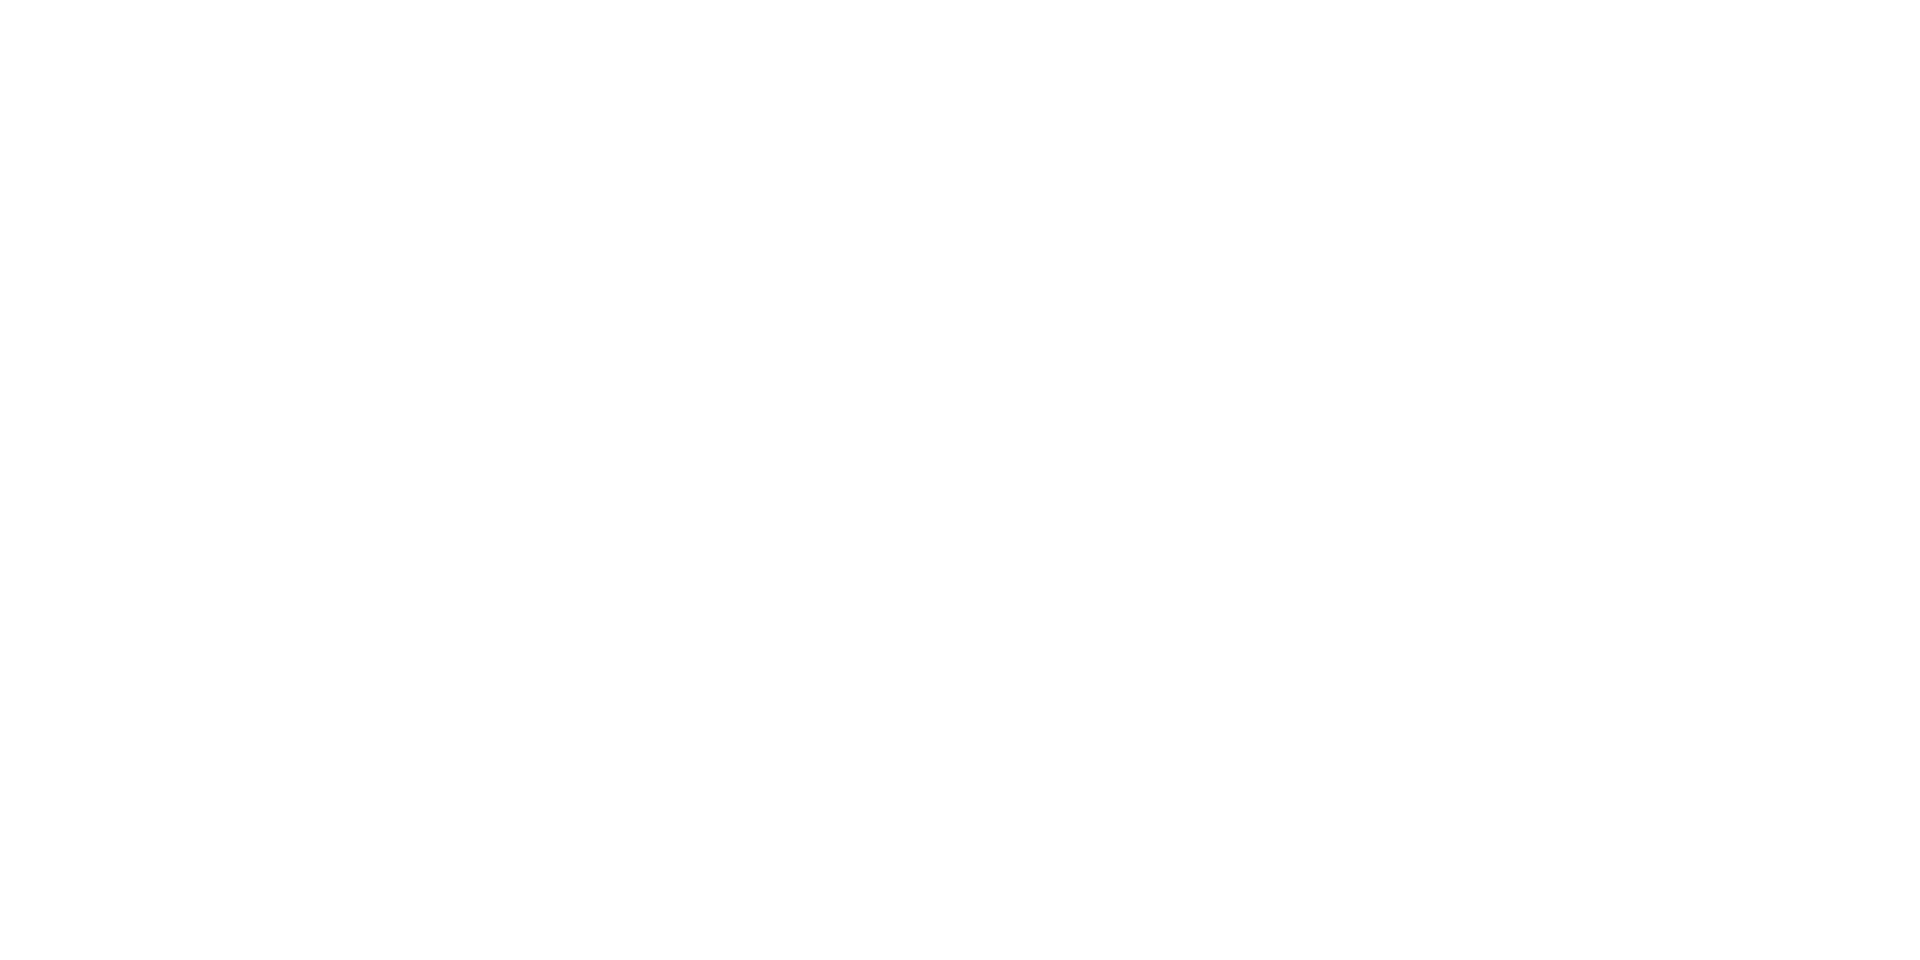

<IPython.core.display.Javascript object>


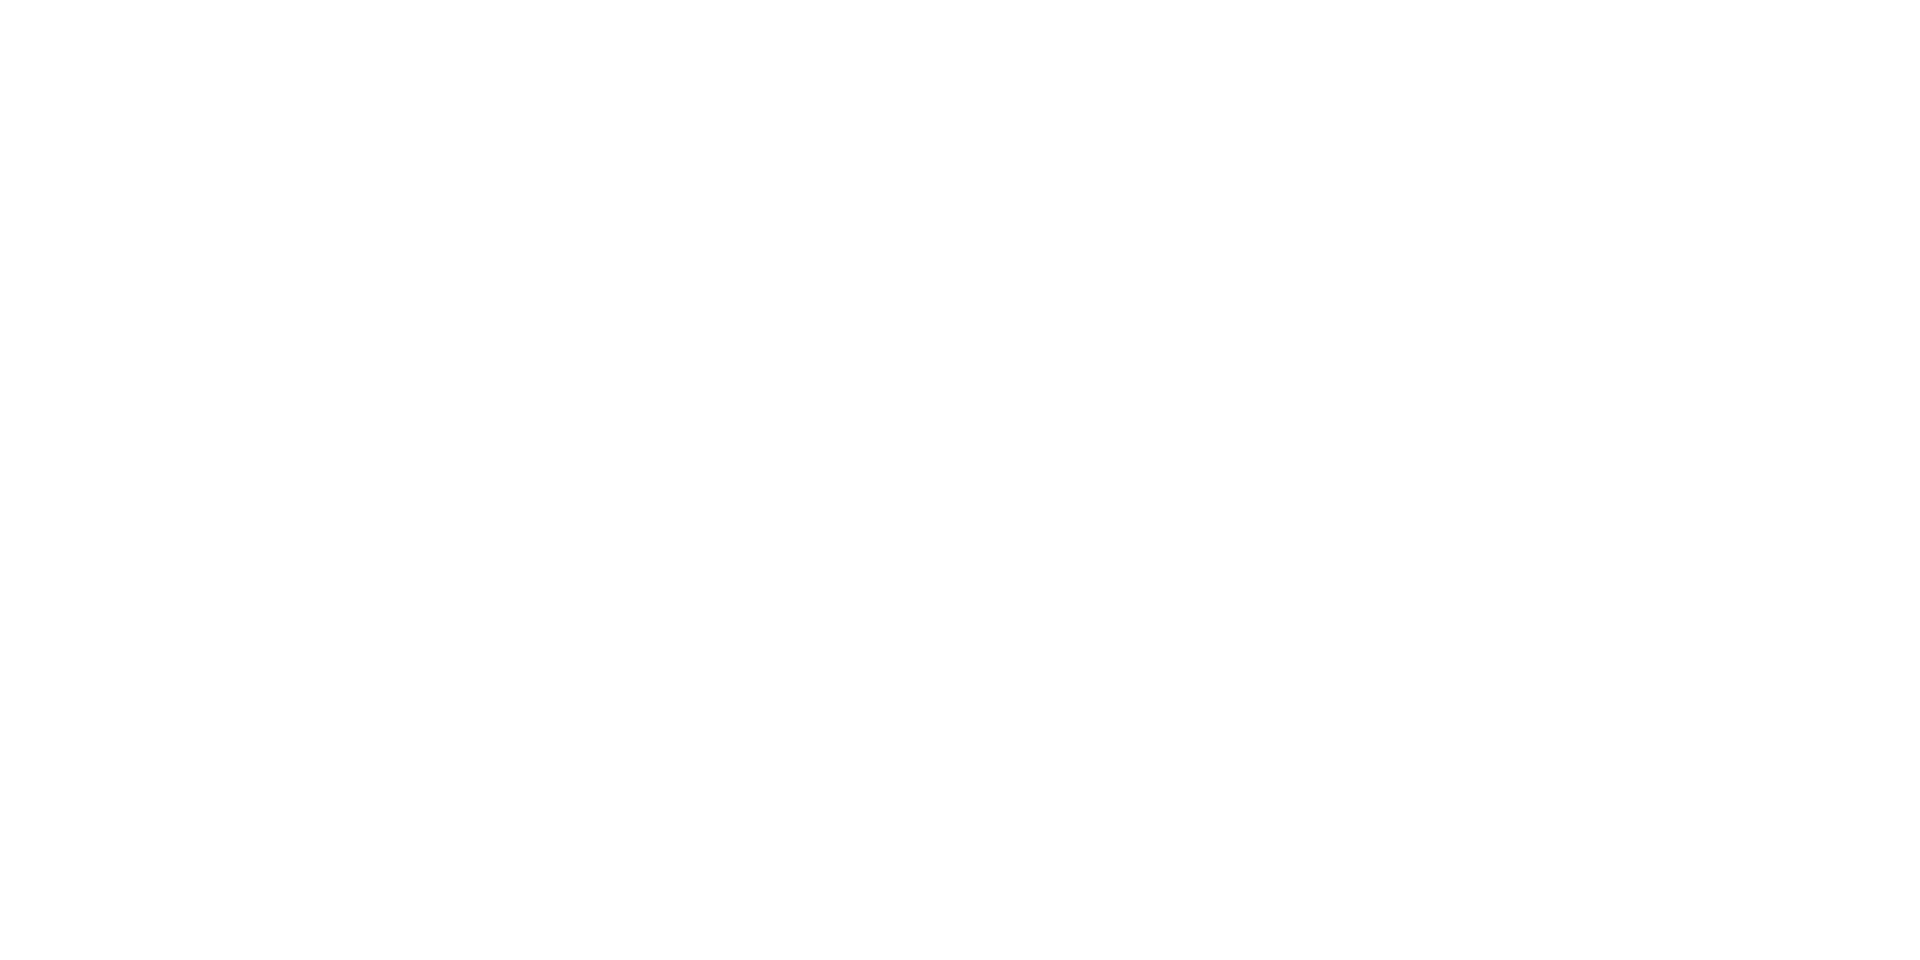

<IPython.core.display.Javascript object>


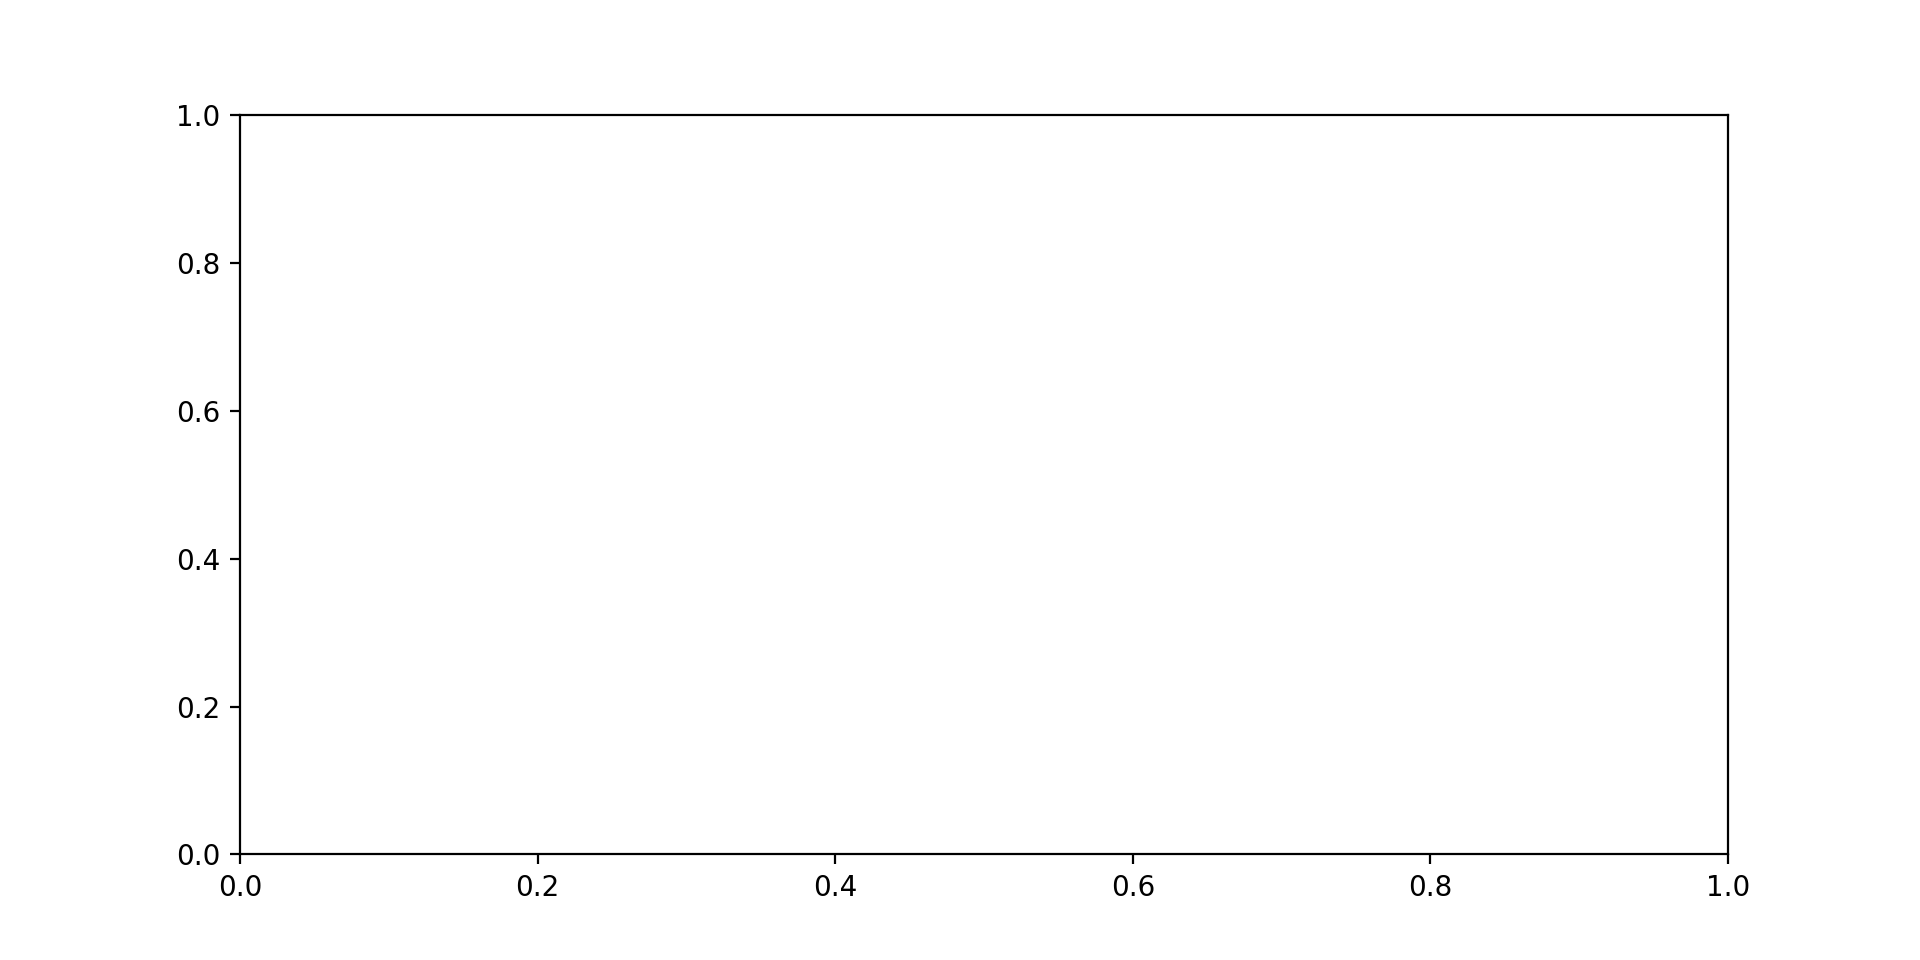

lander env RHL
Landing_icgen:
[[-1.]
 [ 1.]]
AWR Policy: 
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 124)
	xn_init: layer  Linear(in_features=124, out_features=120, bias=True)
	xn_init: layer  Linear(in_features=120, out_features=24, bias=True)
Policy: recurrent steps > 1, disabling shuffle
	Test Mode:          False
	Shuffle :           False
	Shuffle by Chunks:  False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      3
	Advantage Func:     <advantage_utils.Adv_relu object at 0x13a2d5c50>
	Advantage Norm:     <function Adv_normalizer.apply at 0x137274378>
	PD:                 <softmax_pd.Softmax_pd object at 0x13a2d5a20>
Value Funtion
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 25)
	xn_init: layer  Linear(in_features=25, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disablin

In [4]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
import rl_utils
import attitude_utils as attu
import optics_utils as optu
from arch_policy_vf import Arch

from policy_awr import Policy
from softmax_pd import Softmax_pd as PD
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets


from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from rh_constraint import RH_constraint
from no_attitude_constraint import Attitude_constraint
from w_constraint import W_constraint
from reward_attitude import Reward
from hf_asteroid import Asteroid

from thruster_model_cubesat import Thruster_model

from sensor import Sensor
from seeker import Seeker

landing_site_range = 10.0
landing_site = None #np.asarray([-250.,0.,0.])

asteroid_model = Asteroid(landing_site_override=landing_site, omega_range=(1e-5,5e-4))

ap = attu.Quaternion_attitude()

C_cb = optu.rotate_optical_axis(0.0, 0.0, np.pi)
r_cb = np.asarray([0,0,0])
fov=envu.deg2rad(90)
seeker = Seeker(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb,
                radome_slope_bounds=(-0.10,0.10), range_bias=(-0.10,0.10), angle_noise=0.001, 
                   fov=fov, debug=False)
sensor = Sensor(seeker, attitude_parameterization=ap,  use_range=True, apf_tau1=300, use_dp=False,
                      landing_site_range=landing_site_range,
                      pool_type='max', state_type=Sensor.optflow_state_range_dp1)
print(sensor.track_func)
sensor.track_func = sensor.track_func1
print(sensor.track_func)
logger = rl_utils.Logger()
dynamics_model = Dynamics_model(h=2)
thruster_model = Thruster_model(pulsed=True, scale=1.0, offset=0.4)
lander_model = Lander_model(asteroid_model, thruster_model, attitude_parameterization=ap, sensor=sensor, 
                             landing_site_range=landing_site_range, com_range=(-0.10,0.10),
                              attitude_bias=0.10, omega_bias=0.10)

lander_model.get_state_agent = lander_model.get_state_agent_sensor_att_w2

obs_dim = 13
action_dim = 12
actions_per_dim = 2
logit_dim = action_dim * actions_per_dim

recurrent_steps = 60

reward_object = Reward(landing_rlimit=2, landing_vlimit=0.1, 
                       tracking_bias=0.01, fov_coeff=-50., 
                       att_coeff=-0.20,
                       tracking_coeff=-0.5, magv_coeff=-1.0,
                       fuel_coeff=-0.10,  landing_coeff=10.0)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(ap)
w_constraint = W_constraint(w_limit=(0.1,0.1,0.1), w_margin=(0.05,0.05,0.05))
rh_constraint = RH_constraint(rh_limit=150)

wi=0.01
ic_gen = Landing_icgen((800,1000), 
                           p_engine_fail=0.5,
                           engine_fail_scale=(0.5,1.0),
                           lander_wll=(-wi,-wi,-wi),
                           lander_wul=(wi,wi,wi),
                           attitude_parameterization=ap,
                           position_error=(0,np.pi/4),
                           heading_error=(0,np.pi/8),
                           attitude_error=(0,np.pi/16),
                           min_mass=450, max_mass=500,
                           mag_v=(0.05,0.1),
                           debug=False,
                           inertia_uncertainty_diag=10.0,
                           inertia_uncertainty_offdiag=1.0)

env = Env(ic_gen, lander_model, dynamics_model, logger,
          landing_site_range=landing_site_range,
          debug_done=False,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          attitude_constraint=attitude_constraint,
          w_constraint=w_constraint,
          rh_constraint=rh_constraint,
          tf_limit=5000.0,print_every=10,nav_period=6)




env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps,output_network_scale=5), 
               PD(action_dim, actions_per_dim),
               shuffle=False,
               max_grad_norm=30,
               rollout_limit=3,
               kl_limit=0.5,
               init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995,
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "optimize_WATTVW_FOV-AR=5-AWR"
policy.load_params(fname)

# Test Policy 

In [5]:

env.test_policy_batch(agent,5000,print_every=100,keys=lander_model.get_engagement_keys())
#env.test_policy_batch(agent,10,print_every=1)

worked 1
Dynamics: Max Disturbance (m/s^2):  [6.01060121e-06 4.54326022e-06 1.84331514e-06] 7.756697172144481e-06
i (et): 100  (             527)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.08 |  0.62 |  0.00 |  3.46 |    15
glideslope | 2.882 |12.992 | 0.006 |602.936 |    49
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.014 |   0.004 |   0.065
norm_rf  |   0.089 |   0.221 |   0.000 |   1.038
position |    31.1    40.1    51.0 |   190.1   178.0   201.1 |  -382.8  -383.0  -340.1 |   377.8   380.3   405.0
velocity |  -0.003  -0.002  -0.001 |   0.017   0.016   0.016 |  -0.052  -0.048  -0.040 |   0.044   0.041   0.040
fuel     |2.0131 |0.6333 |1.3949 |3.7562
attitude_321 |   0.018   0.105  -0.387 |   1.038   0.709   1.615 |  -3.094  -1.373  -3.120 |   3.061   1.436   3.104
w        | -0.0001  0.0002  0.0001 |  0.0036  0.0041  0.0037 | -0.0119 -0.0114 -0.0091 |  0.0071  0.0089  0.0108
glideslope |   1.297 |   2.330 |   0.011 |  18.333
good_landing |  0.9901 |  0.0990 | 

i (et): 1000  (             499)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.62 |  0.00 |  3.46 |   120
glideslope | 2.668 |11.845 | 0.003 |1248.713 |   584
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.015 |   0.003 |   0.120
norm_rf  |   0.090 |   0.219 |   0.000 |   1.146
position |    10.8     3.9     5.8 |   191.5   173.3   207.6 |  -399.7  -390.9  -407.0 |   401.2   393.6   406.6
velocity |  -0.001  -0.000  -0.001 |   0.017   0.017   0.018 |  -0.067  -0.120  -0.062 |   0.067   0.065   0.066
fuel     |2.0190 |0.6680 |1.3142 |4.5580
attitude_321 |   0.045   0.038  -0.116 |   1.151   0.666   1.813 |  -3.131  -1.427  -3.139 |   3.130   1.537   3.125
w        | -0.0001  0.0001 -0.0001 |  0.0034  0.0039  0.0036 | -0.0128 -0.0121 -0.0105 |  0.0096  0.0143  0.0118
glideslope |   1.420 |   2.646 |   0.003 |  36.559
good_landing |  0.9890 |  0.1043 |  0.0000 |  1.0000
i (et): 1100  (             505)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.

i (et): 1900  (             486)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.62 |  0.00 |  3.46 |   120
glideslope | 2.618 |11.745 | 0.003 |1248.713 |   584
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.015 |   0.002 |   0.120
norm_rf  |   0.086 |   0.210 |   0.000 |   1.146
position |     7.1     6.2     0.3 |   190.2   176.2   206.5 |  -402.5  -406.9  -407.0 |   406.7   395.4   406.6
velocity |  -0.001  -0.000  -0.000 |   0.017   0.016   0.019 |  -0.067  -0.120  -0.076 |   0.067   0.077   0.071
fuel     |2.0182 |0.6717 |1.2465 |4.5580
attitude_321 |   0.043   0.027  -0.053 |   1.178   0.662   1.842 |  -3.131  -1.501  -3.139 |   3.137   1.548   3.139
w        | -0.0000  0.0000 -0.0001 |  0.0035  0.0038  0.0037 | -0.0128 -0.0121 -0.0115 |  0.0119  0.0143  0.0118
glideslope |   1.393 |   2.619 |   0.003 |  54.997
good_landing |  0.9905 |  0.0968 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.00097491 0.00127026 0.00098546] 0.00188020085361806
i (

i (et): 2800  (             472)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.62 |  0.00 |  3.46 |   120
glideslope | 2.620 |11.824 | 0.003 |1984.218 |  1947
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.015 |   0.002 |   0.120
norm_rf  |   0.085 |   0.206 |   0.000 |   1.157
position |     7.7     7.9    -2.9 |   188.4   176.7   206.0 |  -402.5  -406.9  -407.0 |   406.7   405.5   406.6
velocity |  -0.000  -0.001   0.000 |   0.017   0.017   0.019 |  -0.067  -0.120  -0.076 |   0.069   0.077   0.073
fuel     |2.0133 |0.6661 |1.2465 |4.5580
attitude_321 |   0.021   0.028  -0.049 |   1.175   0.652   1.857 |  -3.131  -1.540  -3.139 |   3.137   1.548   3.139
w        | -0.0000  0.0001 -0.0001 |  0.0035  0.0039  0.0037 | -0.0128 -0.0130 -0.0130 |  0.0129  0.0143  0.0119
glideslope |   1.406 |   2.950 |   0.003 |  90.001
good_landing |  0.9914 |  0.0922 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.0010382  0.00127026 0.00119861] 0.0020317697845144696
i

i (et): 3700  (             473)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.62 |  0.00 |  3.46 |  3243
glideslope | 2.633 |11.805 | 0.003 |1984.218 |  1947
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.015 |   0.002 |   0.120
norm_rf  |   0.083 |   0.202 |   0.000 |   1.157
position |     4.0     5.8    -1.0 |   189.7   175.5   205.1 |  -408.4  -406.9  -407.0 |   409.9   405.5   406.6
velocity |  -0.000  -0.001  -0.000 |   0.017   0.017   0.019 |  -0.067  -0.120  -0.076 |   0.069   0.077   0.073
fuel     |2.0125 |0.6624 |1.2465 |4.5580
attitude_321 |   0.020   0.016  -0.044 |   1.180   0.655   1.855 |  -3.134  -1.540  -3.140 |   3.137   1.548   3.140
w        | -0.0000  0.0001 -0.0001 |  0.0035  0.0039  0.0037 | -0.0128 -0.0130 -0.0130 |  0.0138  0.0143  0.0119
glideslope |   1.405 |   2.862 |   0.003 |  90.001
good_landing |  0.9924 |  0.0867 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.0010382  0.00127026 0.00119861] 0.0020317697845144696
i

i (et): 4600  (             444)
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.09 |  0.62 |  0.00 |  3.46 |  3243
glideslope | 2.634 |11.884 | 0.003 |1984.218 |  1947
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.016 |   0.002 |   0.120
norm_rf  |   0.083 |   0.202 |   0.000 |   1.157
position |     3.4     5.3    -1.4 |   189.6   175.7   205.1 |  -408.4  -406.9  -407.0 |   409.9   405.5   406.6
velocity |  -0.000  -0.000  -0.000 |   0.017   0.017   0.019 |  -0.067  -0.120  -0.076 |   0.069   0.077   0.073
fuel     |2.0151 |0.6636 |1.2016 |4.5580
attitude_321 |   0.014   0.013  -0.043 |   1.182   0.655   1.857 |  -3.138  -1.540  -3.140 |   3.137   1.548   3.141
w        | -0.0000  0.0001 -0.0001 |  0.0035  0.0039  0.0037 | -0.0128 -0.0130 -0.0130 |  0.0138  0.0143  0.0142
glideslope |   1.422 |   3.135 |   0.003 |  90.001
good_landing |  0.9924 |  0.0869 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.0010382  0.00127026 0.00119861] 0.0020317697845144696
i

In [5]:
lander_model.show_final_stats()

Final Stats (mean,std,min,max)
norm_vf  |   0.033 |   0.018 |   0.002 |   0.133
norm_rf  |   0.029 |   0.028 |   0.000 |   0.263
position |     0.1    -3.5    -1.4 |   191.6   176.2   205.3 |  -407.3  -406.7  -404.7 |   407.7   405.3   408.8
velocity |   0.000   0.000   0.000 |   0.022   0.021   0.023 |  -0.097  -0.094  -0.088 |   0.102   0.090   0.089
fuel     |1.4343 |0.2856 |0.7433 |2.9872
attitude_321 |   0.002   0.002  -0.005 |   1.187   0.661   1.861 |  -3.141  -1.565  -3.140 |   3.136   1.553   3.141
w        | -0.0000  0.0000 -0.0000 |  0.0035  0.0033  0.0034 | -0.0148 -0.0122 -0.0142 |  0.0147  0.0140  0.0128
glideslope |   1.347 |   2.735 |   0.005 |  91.862
good_landing |  0.9974 |  0.0509 |  0.0000 |  1.0000


<IPython.core.display.Javascript object>


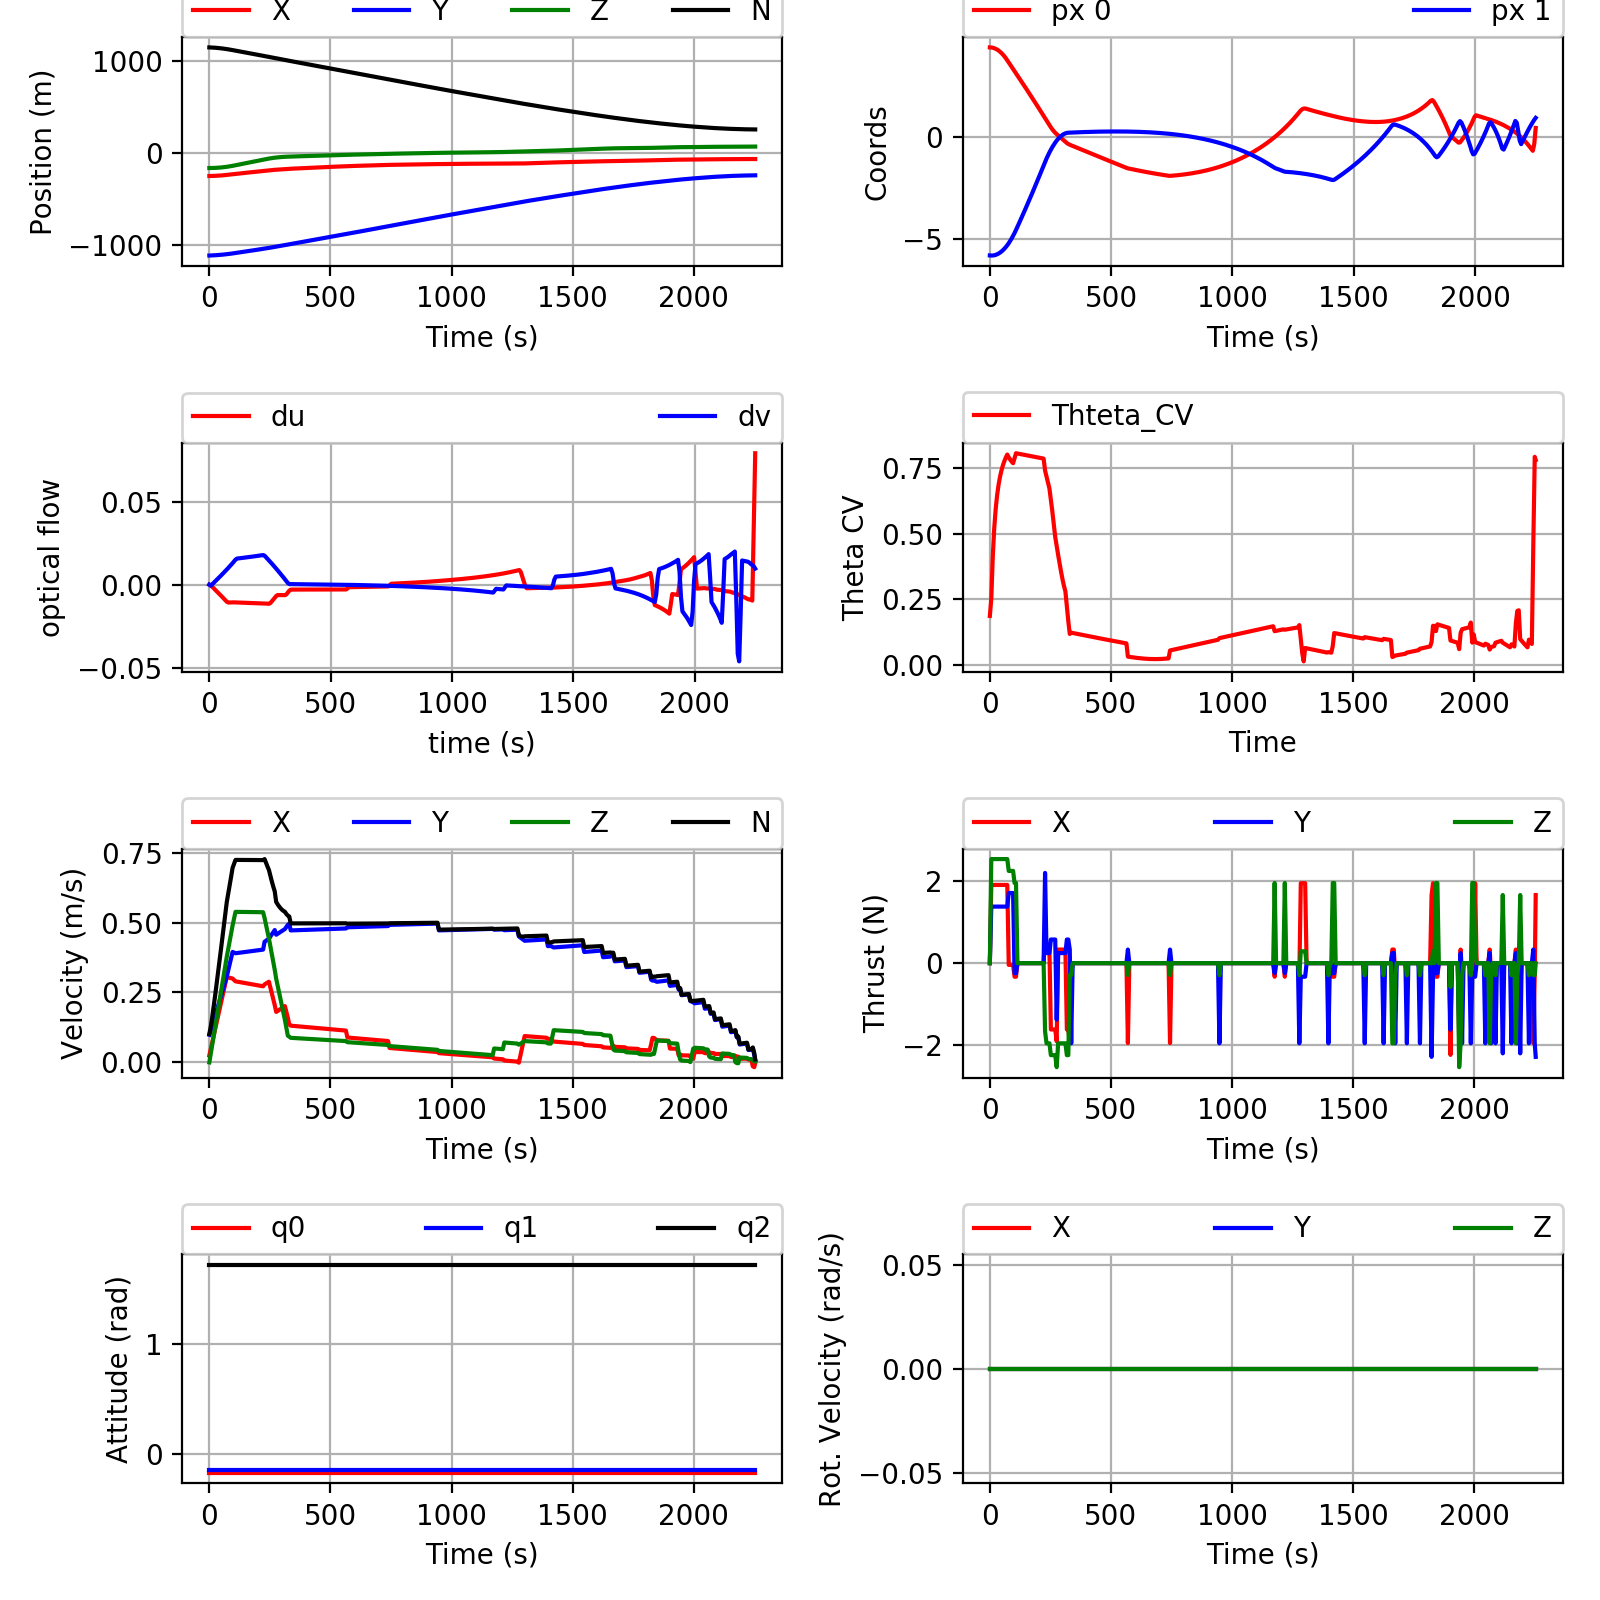

In [27]:
from render_traj_sensor import render_traj
render_traj(lander_model.trajectory_list[0])

In [34]:
print(lander_model.trajectory_list[0]['t'])

[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 78.0, 84.0, 90.0, 96.0, 102.0, 108.0, 114.0, 120.0, 126.0, 132.0, 138.0, 144.0, 150.0, 156.0, 162.0, 168.0, 174.0, 180.0, 186.0, 192.0, 198.0, 204.0, 210.0, 216.0, 222.0, 228.0, 234.0, 240.0, 246.0, 252.0, 258.0, 264.0, 270.0, 276.0, 282.0, 288.0, 294.0, 300.0, 306.0, 312.0, 318.0, 324.0, 330.0, 336.0, 342.0, 348.0, 354.0, 360.0, 366.0, 372.0, 378.0, 384.0, 390.0, 396.0, 402.0, 408.0, 414.0, 420.0, 426.0, 432.0, 438.0, 444.0, 450.0, 456.0, 462.0, 468.0, 474.0, 480.0, 486.0, 492.0, 498.0, 504.0, 510.0, 516.0, 522.0, 528.0, 534.0, 540.0, 546.0, 552.0, 558.0, 564.0, 570.0, 576.0, 582.0, 588.0, 594.0, 600.0, 606.0, 612.0, 618.0, 624.0, 630.0, 636.0, 642.0, 648.0, 654.0, 660.0, 666.0, 672.0, 678.0, 684.0, 690.0, 696.0, 702.0, 708.0, 714.0, 720.0, 726.0, 732.0, 738.0, 744.0, 750.0, 756.0, 762.0, 768.0, 774.0, 780.0, 786.0, 792.0, 798.0, 804.0, 810.0, 816.0, 822.0, 828.0, 834.0, 840.0, 846.0, 852.0, 858.0, 864.0, 870

598
226
[989.7804919684772, 988.3158600046751, 986.7066335746963, 984.9528452845786, 983.0545294712059, 981.0117222709539, 978.8244616930737, 976.4927876981096, 974.0167422816625, 971.3963695638431, 968.6317158847891, 965.7228299066488, 962.6697627224735, 959.4725679724976, 956.1313019683253, 952.6460238255945, 949.0167956057309, 945.2436824674675, 941.3267528288612, 937.338417820765, 933.3444149317106, 929.3446027358434, 925.3455749741504, 921.3386179486075, 917.3148556408258, 913.2741036775387, 909.225030238848, 905.1763972798367, 901.128210737531, 897.0804766554626, 893.0332011860525, 888.9863905930582, 884.9400512540874, 880.8941896631791, 876.8488124334546, 872.8039262998412, 868.7595381218707, 864.7156548865543, 860.6722837113364, 856.6294318471321, 852.5871066814476, 848.5453157415886, 844.5040666979593, 840.4633673674532, 836.4232257169419, 832.3836498668621, 828.344648094905, 824.3062288398127, 820.2684007052835, 816.2311724639915, 812.1945530617214, 808.1585516216263, 804.123

<IPython.core.display.Javascript object>


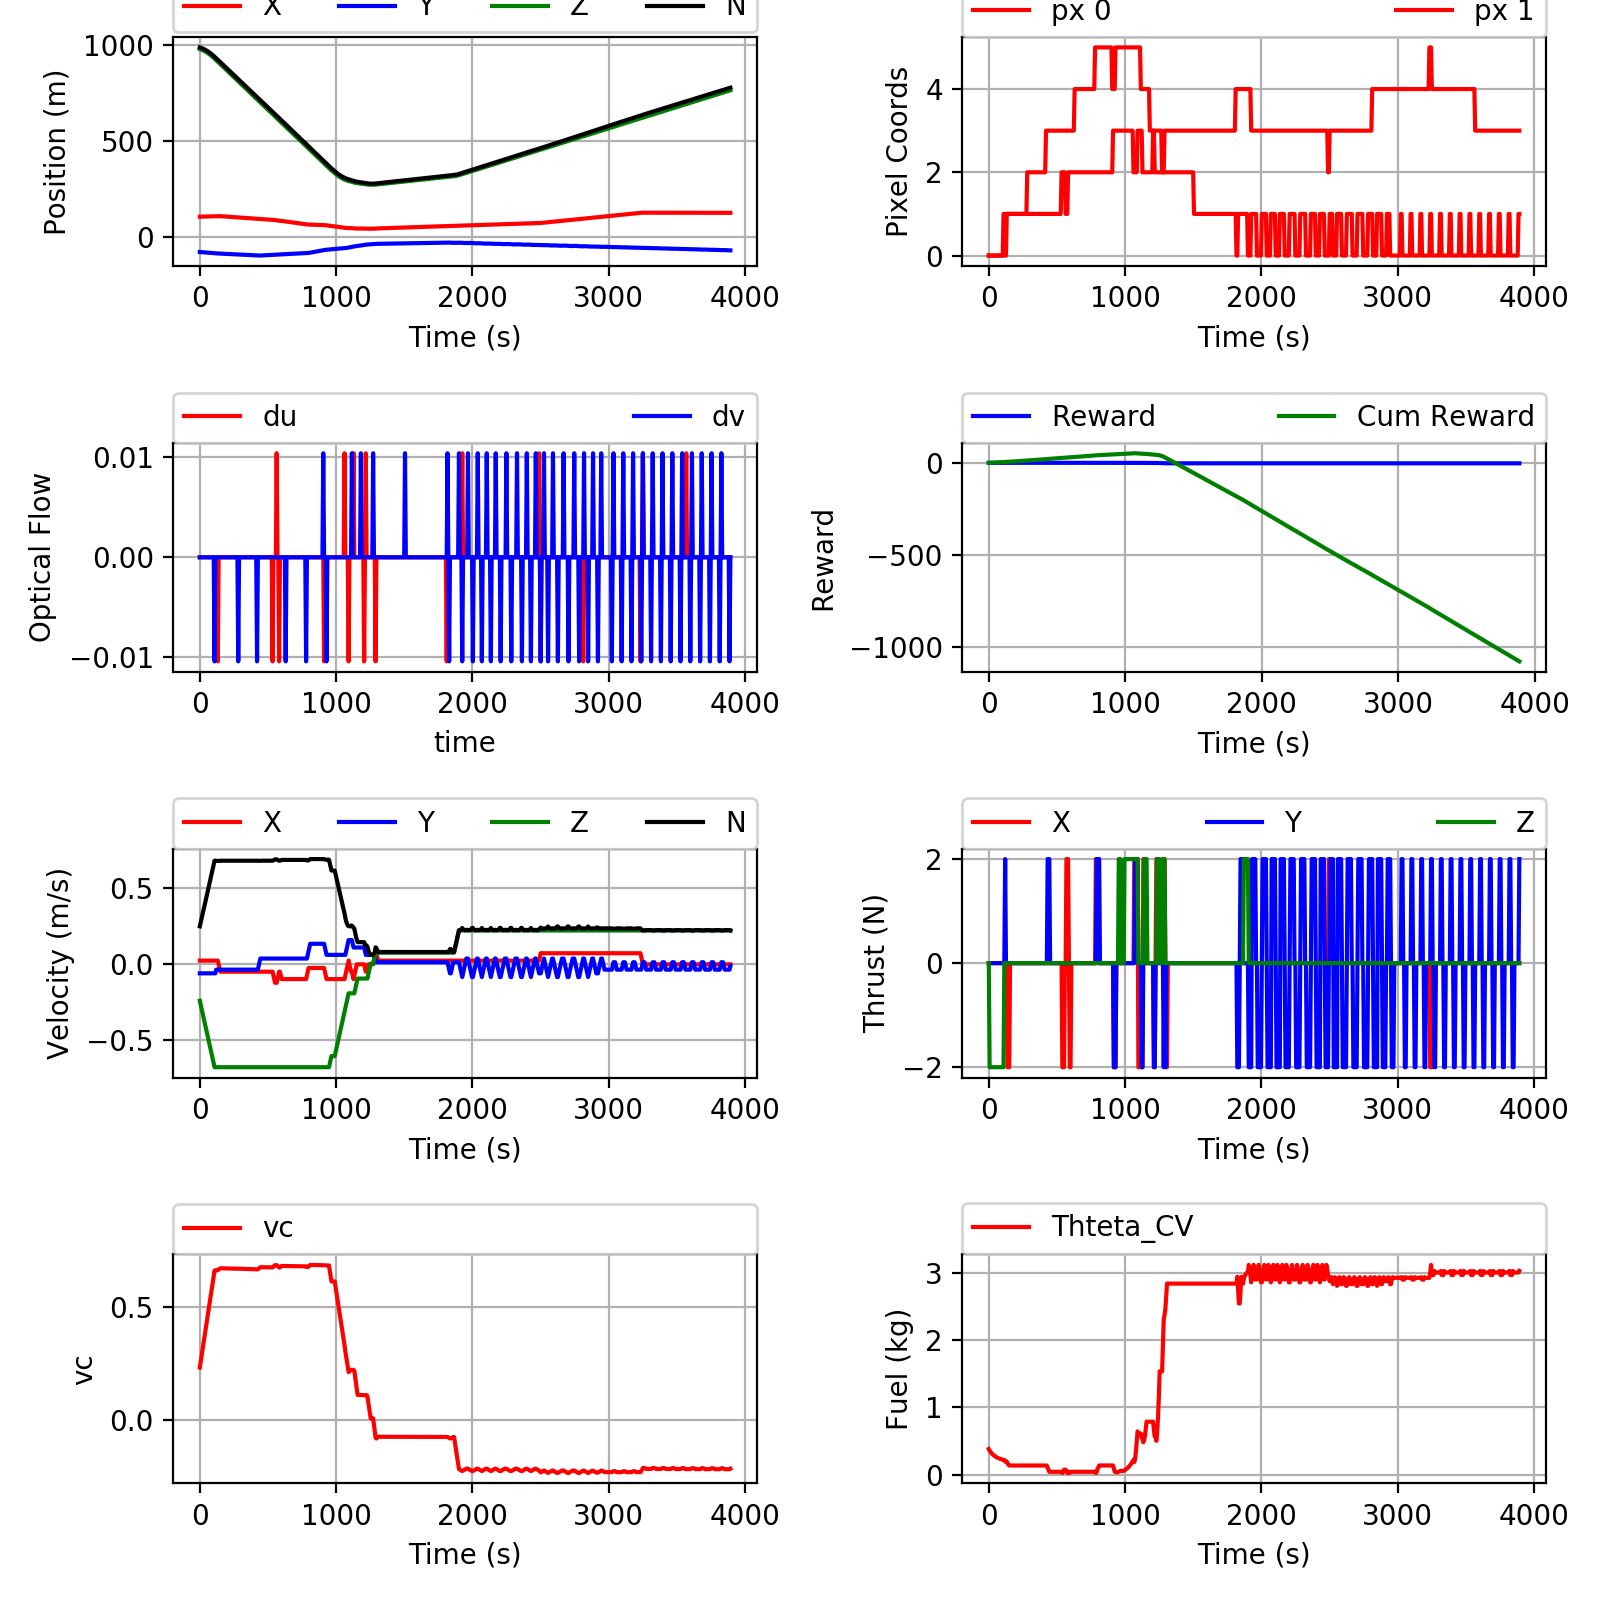

In [21]:
tl = lander.trajectory_list.copy()
rf_list = []
print(len(lander_model.trajectory_list))
for t in lander_model.trajectory_list:
    rf_list.append(t['norm_rf'][-1])
    
idx = np.argmax(rf_list)
print(idx)
wc = lander_model.trajectory_list[idx]
print(wc['norm_rf'])
#print(rf_list)
envu.render_traj(wc)

In [6]:

lander_model.offset_pixels = False
policy.test_mode=True                          
env.test_policy_batch(agent,50000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.989 |19.070 | 1.400 |420.273 |    70
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.235 |   0.039 |   0.121 |   0.366
norm_rf  |     0.3 |     0.1 |     0.0 |     0.6
position |    -0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.2    -0.2    -0.6 |     0.1     0.1     0.2
velocity |  -0.010   0.010  -0.229 |   0.035   0.038   0.040 |  -0.081  -0.068  -0.352 |   0.091   0.093  -0.118
fuel     |  2.91 |  0.22 |  2.49 |  3.49
glideslope |  8.03 | 11.17 |  2.18 | 80.66
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.76 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.214 |17.472 | 1.400 |420.273 |    70
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.042 |   0.121 |   0.419
norm_rf  |     0.3 |     0.1 |     0.0 |     0.8
position |    -0.0    -0.0

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.939 |19.279 | 1.343 |1592.393 |   856
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.113 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.2    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.006   0.006  -0.234 |   0.037   0.039   0.040 |  -0.139  -0.113  -0.410 |   0.113   0.141  -0.108
fuel     |  2.90 |  0.21 |  2.34 |  3.60
glideslope |  8.56 | 12.03 |  2.16 |198.71
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.908 |19.231 | 1.343 |1592.393 |   856
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.113 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.036 |20.600 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.107 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.2    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.006   0.006  -0.233 |   0.036   0.039   0.040 |  -0.139  -0.128  -0.410 |   0.113   0.145  -0.106
fuel     |  2.90 |  0.21 |  2.34 |  3.77
glideslope |  8.73 | 12.44 |  2.01 |283.41
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.992 |20.412 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.107 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.951 |20.922 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.005   0.006  -0.233 |   0.036   0.039   0.040 |  -0.156  -0.128  -0.410 |   0.117   0.145  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.77
glideslope |  8.77 | 14.31 |  2.01 |410.33
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.980 |20.924 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  5300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.024 |21.323 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.005   0.006  -0.233 |   0.036   0.039   0.040 |  -0.156  -0.128  -0.410 |   0.117   0.145  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.77
glideslope |  8.84 | 14.30 |  1.98 |410.33
i :  5400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.998 |21.275 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.929 |21.207 | 1.343 |2107.977 |  1858
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.006   0.006  -0.233 |   0.036   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.117   0.145  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.77
glideslope |  8.84 | 15.49 |  1.93 |546.41
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |10.950 |21.887 | 1.343 |2883.957 |  6671
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.094 |29.190 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.3     0.3     0.2
velocity |  -0.005   0.006  -0.233 |   0.036   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.117   0.151  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.77
glideslope |  8.88 | 16.68 |  1.93 |702.93
i :  8000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.097 |29.113 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.081 |28.365 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.006  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.117   0.151  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.77
glideslope |  8.90 | 16.45 |  1.84 |702.93
i :  9300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.083 |28.304 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    

i :  10500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.100 |27.929 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.119   0.151  -0.081
fuel     |  2.90 |  0.21 |  2.32 |  3.88
glideslope |  8.90 | 16.41 |  1.84 |702.93
i :  10600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.075 |27.836 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  11800
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.184 |27.756 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.128   0.151  -0.081
fuel     |  2.90 |  0.21 |  2.31 |  3.88
glideslope |  8.89 | 15.87 |  1.84 |702.93
i :  11900
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.200 |27.725 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  13100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.147 |27.167 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.410 |   0.128   0.151  -0.081
fuel     |  2.90 |  0.21 |  2.31 |  3.88
glideslope |  8.95 | 16.87 |  1.84 |702.93
i :  13200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.147 |27.107 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.419
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  14400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.163 |27.187 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.21 |  2.31 |  3.88
glideslope |  8.94 | 16.52 |  1.79 |702.93
i :  14500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.197 |27.192 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  15700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.194 |27.389 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.21 |  2.31 |  3.88
glideslope |  8.94 | 16.46 |  1.79 |702.93
i :  15800
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.200 |27.351 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  17000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.184 |26.968 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.3    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.21 |  2.30 |  3.88
glideslope |  8.98 | 17.49 |  1.79 |760.73
i :  17100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.189 |26.931 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  18300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.165 |26.738 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.88
glideslope |  8.98 | 17.39 |  1.79 |760.73
i :  18400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.150 |26.721 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

glideslope |  8.96 | 17.06 |  1.79 |760.73
i :  19600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.173 |26.491 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.88
glideslope |  8.95 | 17.04 |  1.79 |760.73
i :  19700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.180 |26.477 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0

i :  20900
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.159 |26.105 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.159  -0.081
fuel     |  2.90 |  0.21 |  2.25 |  3.88
glideslope |  8.95 | 16.89 |  1.79 |760.73
i :  21000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.156 |26.071 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  22200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.229 |26.660 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.2 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.21 |  2.25 |  3.93
glideslope |  8.94 | 16.61 |  1.79 |760.73
i :  22300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.221 |26.634 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

i :  23500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.208 |26.819 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.21 |  2.25 |  3.93
glideslope |  8.91 | 16.38 |  1.79 |760.73
i :  23600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.194 |26.773 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0  

glideslope |  8.90 | 16.60 |  1.79 |760.73
i :  24800
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.179 |27.193 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.005   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.90 | 16.58 |  1.79 |760.73
i :  24900
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.176 |27.161 | 1.343 |8066.854 |  7853
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0

glideslope |  8.88 | 16.35 |  1.79 |760.73
i :  26100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.176 |27.172 | 1.343 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.3     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.162  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.88 | 16.32 |  1.79 |760.73
i :  26200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.173 |27.150 | 1.343 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0

velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.89 | 16.24 |  1.79 |760.73
i :  27400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.212 |27.429 | 1.343 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.90 | 16.22 |  1.79 |760.73
i :  27500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.219 |27.424 | 1.343 |8983.149 | 25127
sc_mar

fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.87 | 16.25 |  1.79 |760.73
i :  28700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.203 |27.265 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.87 | 16.24 |  1.79 |760.73
i :  28800
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.199 |27.242 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.239 |   0.040 |   0

velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.88 | 16.13 |  1.79 |760.73
i :  30000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.231 |27.290 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.25 |  3.93
glideslope |  8.87 | 16.10 |  1.79 |760.73
i :  30100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.238 |27.325 | 1.246 |8983.149 | 25127
sc_mar

fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.87 | 16.15 |  1.79 |760.73
i :  31300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.236 |27.150 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.86 | 16.13 |  1.79 |760.73
i :  31400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.227 |27.116 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0

fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.88 | 16.06 |  1.79 |760.73
i :  32600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.258 |27.244 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.87 | 16.05 |  1.79 |760.73
i :  32700
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.268 |27.237 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0

velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.91 | 16.25 |  1.78 |760.73
i :  33900
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.268 |27.002 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.91 | 16.23 |  1.78 |760.73
i :  34000
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.267 |26.987 | 1.246 |8983.149 | 25127
sc_mar

norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.89 | 16.18 |  1.78 |760.73
i :  35200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.77 |  0.47 |  0.00 |  3.46 |     0
glideslope |11.252 |27.310 | 1.246 |8983.149 | 25127
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.240 |   0.040 |   0.083 |   0.478
norm_rf  |     0.2 |     0.1 |     0.0 |     0.8
position |     0.0    -0.0    -0.2 |     0.1     0.1     0.1 |    -0.3    -0.4    -0.7 |     0.4     0.4     0.2
velocity |  -0.006   0.007  -0.233 |   0.037   0.039   0.040 |  -0.166  -0.128  -0.447 |   0.128   0.163  -0.081
fuel     |  2.90 |  0.22 |  2.21 |  3.93
glideslope |  8.88 | 16.16 |  1.78 |760

KeyboardInterrupt: 

In [ ]:
lander_model.trajectory_list = []

<IPython.core.display.Javascript object>


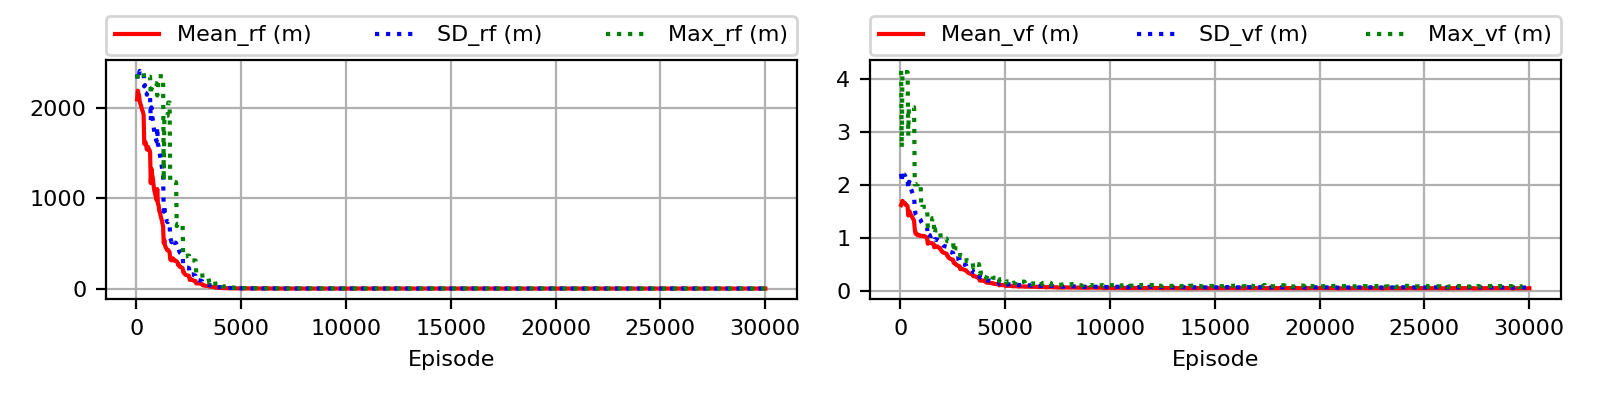

In [17]:


envu.plot_rf_vf(env.rl_stats.history)


Cumulative Stats (mean,std,max,argmax)
thrust   |  0.90 |  1.16 |  0.00 |  3.46 |     0
glideslope | 1.531 | 9.389 | 0.541 |100.000 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.032 |   0.000 |   0.032 |   0.032
norm_rf  |     0.2 |     0.0 |     0.2 |     0.2
position |     0.2     0.0    -0.0 |     0.0     0.0     0.0 |     0.2     0.0    -0.0 |     0.2     0.0    -0.0
velocity |  -0.013   0.002  -0.029 |   0.000   0.000   0.000 |  -0.013   0.002  -0.029 |  -0.013   0.002  -0.029
fuel     |  0.97 |  0.00 |  0.97 |  0.97
glideslope |  0.66 |  0.00 |  0.66 |  0.66

Initial Stats (mean,std,min,max)
norm_vf  |   0.110 |   0.000 |   0.110 |   0.110
norm_rf  |  1694.2 |     0.0 |  1694.2 |  1694.2
position |  1035.1   990.6   904.2 |     0.0     0.0     0.0 |  1035.1   990.6   904.2 |  1035.1   990.6   904.2
velocity |   0.042  -0.055  -0.086 |   0.000   0.000   0.000 |   0.042  -0.055  -0.086 |   0.042  -0.055  -0.086
fuel    

<IPython.core.display.Javascript object>


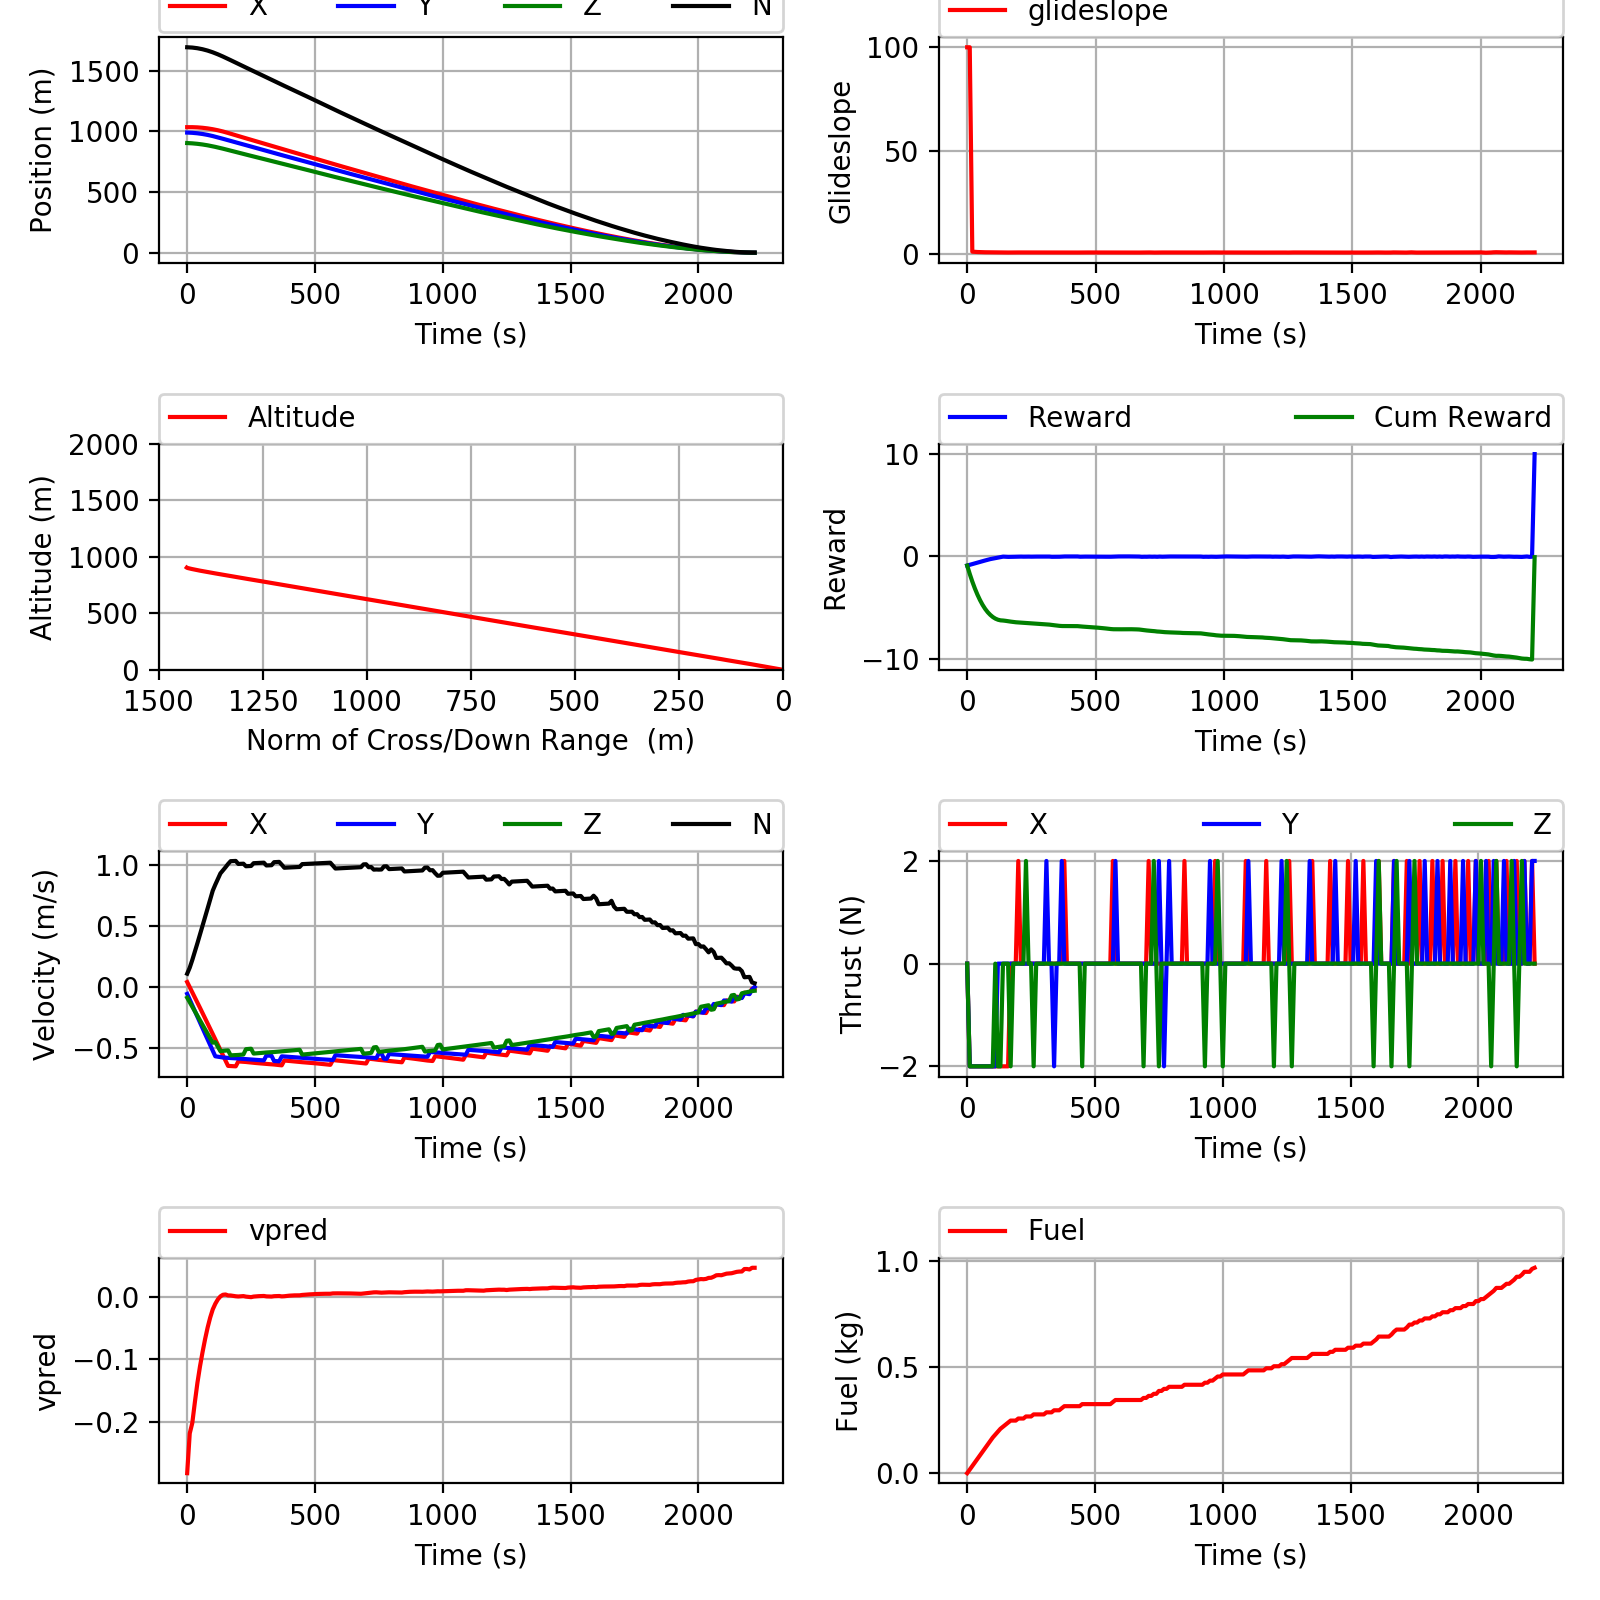

In [34]:
min_g   = -100e-6
max_g   = -1e-6
min_w   = 1.0e-3
max_w   = 1.0e-3
min_srp = -1e-6
max_srp =  1e-6
r = 1000
d = 100
env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            downrange =  (r - d, r + d, -0.1, 0.1), 
                            crossrange = (r - d, r + d, -0.1, 0.1),  
                            altitude =   (r - d, r + d, -0.1, 0.1),
                            min_mass = 450, max_mass=500,
                            min_g=(min_g,min_g,min_g),  max_g=(max_g,max_g,max_g),
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w),
                            min_srp=(min_srp,min_srp,min_srp), max_srp=(max_srp,max_srp,max_srp))
env.test_policy_batch(agent,1,print_every=1)
envu.render_traj(lander_model.trajectory_list[0])

In [15]:
r = 3
d=0.1
dr = 1
dt = 1/np.sqrt(1-d**2/r**2)*dr
print(dt)

1.000556018947605


In [18]:
d = 0.1
r1 = 100
r2 = 101
theta1 = np.arcsin(d/r1)
theta2 = np.arcsin(d/r2)
print(theta1-theta2)

9.900995000655406e-06


In [12]:
fov = np.pi-np.pi/4
#fov = np.pi/2
dotlim = np.cos(fov/2)
print(dotlim)

0.38268343236508984


In [30]:
np.linalg.norm([1,1])

1.4142135623730951

In [42]:
from angle_sensor import Angle_sensor
sensor = Angle_sensor()
object_loc = np.zeros(3)
agent_position = 1.0*np.asarray([0,0,1000])
agent_velocity = 1.0*np.asarray([-0.3,0.3,-1])
x,y=sensor.get_angles_3dof(agent_position, agent_velocity, object_loc)
print(x,y)

orp:  [    0.     0. -1000.]
xyz:  -276.1723853694967 276.1723853694967 920.5746178983229
-0.2914567944778669 0.2914567944778669


In [29]:
agent_position = 1.0*np.asarray([1000,1000,1000])
agent_velocity = 1.0*np.asarray([-0.0,0.0,-1])
x,y=sensor.get_angles_3dof(agent_position, agent_velocity, object_loc)
print(x,y)

0.7853981633974484 -0.7853981633974484


In [8]:
cv1 = np.pi*1.4**2*1.4/3
cv2 = np.pi*1.0**2*0.9/3
print(cv1,cv2,cv1-cv2)

2.8735100804834635 0.9424777960769379 1.9310322844065255


In [9]:
cv1 = np.pi*1.2**2*1.2/3
cv2 = np.pi*0.9**2*0.9/3
print(cv1,cv2,cv1-cv2)

1.8095573684677209 0.7634070148223198 1.046150353645401


In [15]:
p = 1.0*np.asarray([100,100,100])

n = p/np.linalg.norm(p)
r = 1.0*np.asarray([100,100,0])
rv = r-p
rv /= np.linalg.norm(rv)
print(np.dot(n,rv))

-0.5773502691896257
